# Track Energy

Notebook to track energy throughout the car to analyze energy discrepancies and if sensor calibration is needed

## Imports and Init

In [12]:
from data_tools.collections.time_series import TimeSeries
from data_tools.query.influxdb_query import DBClient
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import datetime

# Start and stop dates/times to query from Influx
# NOTE: TIMES SHOULD BE IN UTC
start = "2024-07-18T15:00:00Z"
start = datetime.datetime.strptime(start[:-1], "%Y-%m-%dT%H:%M:%S").replace(tzinfo=datetime.timezone.utc)
stop = "2024-07-18T21:00:00Z"
stop = datetime.datetime.strptime(stop[:-1], "%Y-%m-%dT%H:%M:%S").replace(tzinfo=datetime.timezone.utc)

# Parameters for Savitsky-Golav filter. SEE https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter
WINDOW_SIZE = 20
POLYNOMIAL_ORDER = 2

client = DBClient()

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


### Necessary Functions 
Functions to align **TimeSeries** objects and get signed battery current, pack power, and motor power.

In [13]:
def get_signed_battery_current(battery_current_direction: TimeSeries, battery_current: TimeSeries) -> TimeSeries:
    # Ensure that the input time series are aligned before multiplication
    battery_current_direction, battery_current = TimeSeries.align(battery_current_direction, battery_current)

    # Convert direction to be -1 or 1 for scalar multiplication
    masked_direction = np.where(battery_current_direction == 0, 1, -1)
    
    signed_current_data = masked_direction * battery_current

    # Create the metadata for the signed current TimeSeries
    signed_current_meta = {
        "start": battery_current_direction.start,
        "stop": battery_current_direction.stop,
        "car": battery_current_direction.meta["car"],
        "measurement": battery_current_direction.meta["measurement"],
        "field": "SignedBatteryCurrent",
        "granularity": battery_current_direction.granularity,
        "length": battery_current_direction.length,
        "units": "A",
    }

    # Create and return the new TimeSeries object
    signed_current = TimeSeries(signed_current_data, signed_current_meta)
    return signed_current

def get_power(current: TimeSeries, voltage: TimeSeries, new_field_name: str, units: str) -> TimeSeries:
    # Ensure that the input time series are aligned before multiplication
    current, voltage = TimeSeries.align(current, voltage)
    
    power_data = current * voltage

    # Create the metadata for the power TimeSeries
    power_meta = {
        "start": voltage.start,
        "stop": voltage.stop,
        "car": voltage.meta["car"],
        "measurement": voltage.meta["measurement"],
        "field": new_field_name,
        "granularity": voltage.granularity,
        "length": voltage.length,
        "units": units,
    }

    # Create and return the new TimeSeries object
    power = TimeSeries(power_data, power_meta)
    return power

def summarize_timeseries(timeseries_data):
    data = np.array(timeseries_data)
    
    mean = np.mean(data)
    std = np.std(data)
    
    # Interquartile range (IQR)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    # Get 1st and 99th percentiles for the majority of the data
    p1 = np.percentile(data, 1)
    p99 = np.percentile(data, 99)
    
    # Get the max and min values
    max_value = np.max(data)
    min_value = np.min(data)
    
    # Return the metrics
    return {
        "mean": mean,
        "std": std,
        "iqr": iqr,
        "1st_percentile": p1,
        "99th_percentile": p99,
        "majority_interval": (p1, p99),
        "max": max_value,
        "min": min_value
    }

## Setup
Query and fetch necessary data from Influx then calculate power from current and voltage, and analyze power plots from components 

In [14]:
# Battery Queries
battery_current: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryCurrent", units="A")
battery_voltage: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryVoltage", units="V")
battery_current_direction: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryCurrentDirection")

In [15]:
# Pack Queries
pack_current: TimeSeries = client.query_time_series(start=start, stop=stop, field="PackCurrent", units="A")
pack_voltage: TimeSeries = client.query_time_series(start=start, stop=stop, field="TotalPackVoltage", units="V")

In [16]:
# Array/AMB queries
amb_volt1: TimeSeries = client.query_time_series(start=start, stop=stop, field="VoltSensor1", units="V")
amb_volt2: TimeSeries = client.query_time_series(start=start, stop=stop, field="VoltSensor2", units="V")
amb_curr1: TimeSeries = client.query_time_series(start=start, stop=stop, field="CurrentSensor1", units="A")
amb_curr2: TimeSeries = client.query_time_series(start=start, stop=stop, field="CurrentSensor2", units="A")

Get power from fetched data

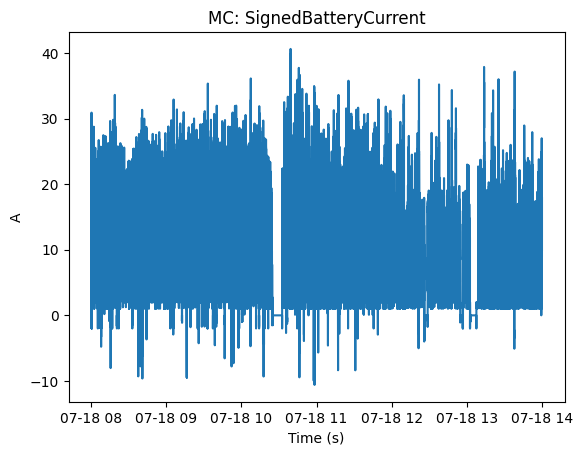

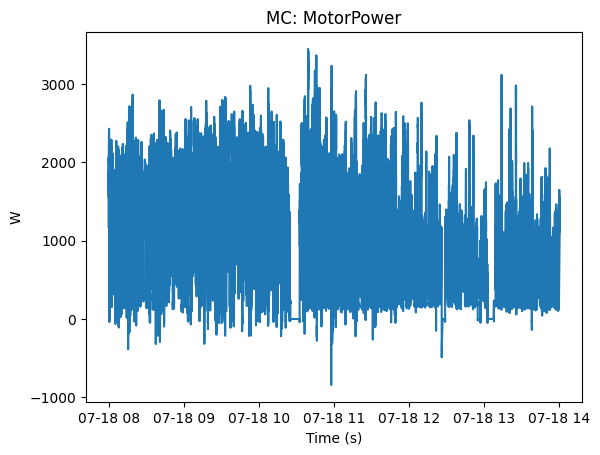

Filtered Motor Power:  [1178.22499083 1282.8833512  1378.29027238 ... 1273.1703358  1232.99356771
 1187.29521331]
{'mean': np.float64(1068.7324929352687), 'std': np.float64(671.280247894328), 'iqr': np.float64(1112.6212682534047), '1st_percentile': np.float64(0.0), '99th_percentile': np.float64(2485.7099455404227), 'majority_interval': (np.float64(0.0), np.float64(2485.7099455404227)), 'max': np.float64(3451.4353806924037), 'min': np.float64(-842.4814640026427)}


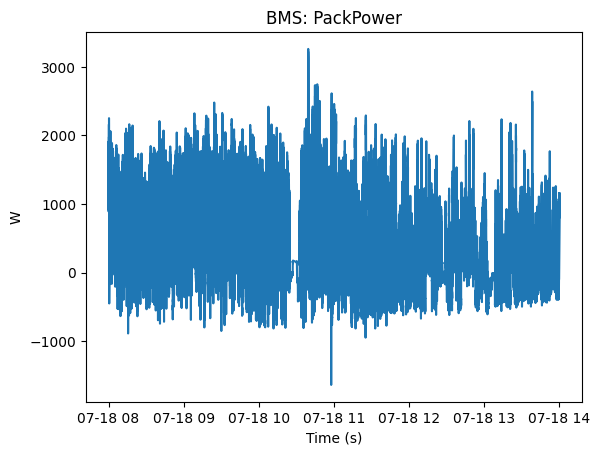

Filtered Pack Power:  [ 926.09836476  985.89365151 1042.25024637 ... 1093.76441682 1123.70909908
 1155.53077754]
{'mean': np.float64(559.2844335142082), 'std': np.float64(654.8735613598639), 'iqr': np.float64(1055.3792702920396), '1st_percentile': np.float64(-582.3485969529399), '99th_percentile': np.float64(1979.408938071153), 'majority_interval': (np.float64(-582.3485969529399), np.float64(1979.408938071153)), 'max': np.float64(3262.2533165648065), 'min': np.float64(-1639.7974354187545)}


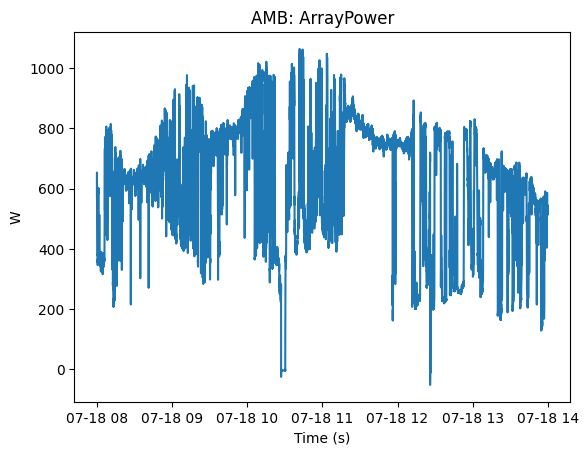

Filtered Array Power:  [569.45941587 582.68932085 594.77258951 ... 525.17211453 526.33633197
 527.75007352]
{'mean': np.float64(611.3333892729846), 'std': np.float64(203.39274739008775), 'iqr': np.float64(297.9713737984008), '1st_percentile': np.float64(-3.100102684538576), '99th_percentile': np.float64(959.5229013335719), 'majority_interval': (np.float64(-3.100102684538576), np.float64(959.5229013335719)), 'max': np.float64(1064.1832641494739), 'min': np.float64(-52.212545655425416)}


In [17]:
# Get signed battery current
signed_current = get_signed_battery_current(battery_current_direction, battery_current)
signed_current.plot()
# Get power
motor_power = get_power(signed_current, battery_voltage, "MotorPower", "W")
pack_power = get_power(pack_current, pack_voltage, "PackPower", "W")
array_power1 = get_power(amb_curr1, amb_volt1, "ArrayPower1", "W")
array_power2 = get_power(amb_curr2, amb_volt2, "ArrayPower2", "W")

# Get total power from arrays
array_power_data = array_power1 + array_power2

# Create the metadata for the power TimeSeries
array_power_meta = {
    "start": array_power1.start,
    "stop": array_power1.stop,
    "car": array_power1.meta["car"],
    "measurement": array_power1.meta["measurement"],
    "field": "ArrayPower",
    "granularity": array_power1.granularity,
    "length": array_power1.length,
    "units": array_power1.units,
}

# Create and return the new TimeSeries object
array_power = TimeSeries(array_power_data, array_power_meta)

# Clean data
filtered_motor_power = motor_power.promote(signal.savgol_filter(motor_power, WINDOW_SIZE, POLYNOMIAL_ORDER))
filtered_pack_power = pack_power.promote(signal.savgol_filter(pack_power, WINDOW_SIZE, POLYNOMIAL_ORDER))
filtered_array_power = array_power.promote(signal.savgol_filter(array_power, WINDOW_SIZE, POLYNOMIAL_ORDER))

# Visualize
filtered_motor_power.plot()
print("Filtered Motor Power: ", filtered_motor_power)
print(summarize_timeseries(filtered_motor_power))
filtered_pack_power.plot()
print("Filtered Pack Power: ", filtered_pack_power)
print(summarize_timeseries(filtered_pack_power))
filtered_array_power.plot()
print("Filtered Array Power: ", filtered_array_power)
print(summarize_timeseries(filtered_array_power))

## Analysis
The assumption is that **Pack Power = Motor Power - Array Power**, take the difference between *Motor Power* and *Array Power* and plot the observed discrepencies with *Pack Power*

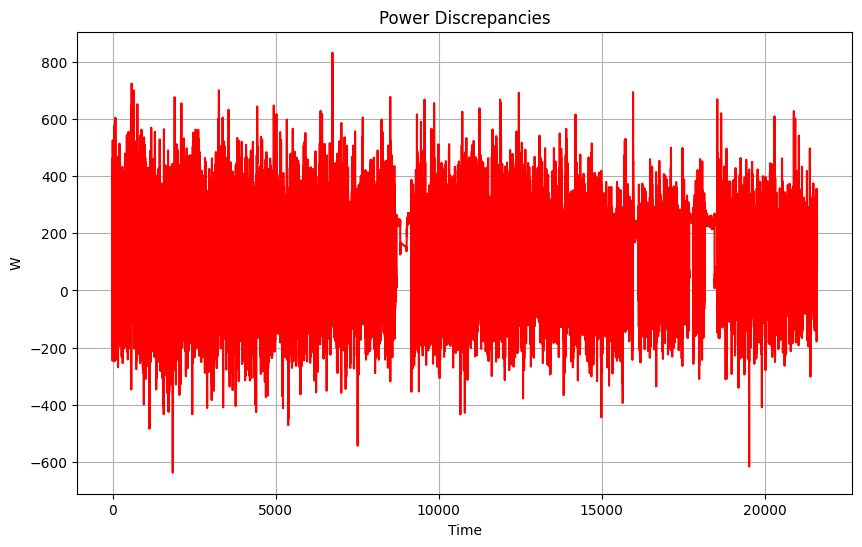

[-192.36367104 -158.01181005 -167.75145156 ...  275.43793529  334.41377541
  337.97833485]
Mean Power Discrepancy:  101.90193078878478
{'mean': np.float64(101.90193078878478), 'std': np.float64(122.13381188674525), 'iqr': np.float64(153.44181044424894), '1st_percentile': np.float64(-190.34138451112844), '99th_percentile': np.float64(409.70883246977036), 'majority_interval': (np.float64(-190.34138451112844), np.float64(409.70883246977036)), 'max': np.float64(832.8046516405238), 'min': np.float64(-638.3410812322044)}


In [18]:
# Get the deficit in power then get the discrepancy
filtered_motor_power, filtered_array_power = TimeSeries.align(filtered_motor_power, filtered_array_power)
deficit = filtered_motor_power - filtered_array_power 

filtered_pack_power, deficit = TimeSeries.align(filtered_pack_power, deficit)
discrepancy = filtered_pack_power - deficit

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(discrepancy.x_axis, discrepancy, color='red', linestyle='-')

# Add titles and labels
plt.title('Power Discrepancies')
plt.xlabel('Time')
plt.ylabel('W')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

print(discrepancy)
print("Mean Power Discrepancy: ", np.mean(discrepancy))
print(summarize_timeseries(discrepancy))

<Figure size 1000x600 with 0 Axes>

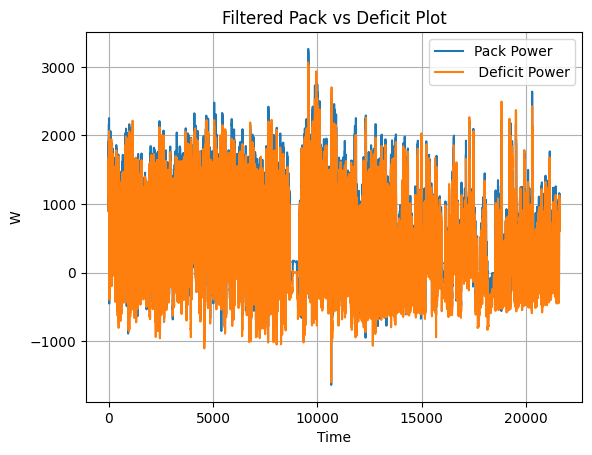

In [19]:
# Create the plot
plt.figure(figsize=(10, 6))

fig, ax = plt.subplots()
ax.plot(filtered_pack_power.x_axis, filtered_pack_power, label="Pack Power")
ax.plot(filtered_pack_power.x_axis, deficit, label=" Deficit Power")

# Add titles and labels
plt.title('Filtered Pack vs Deficit Plot')
plt.xlabel('Time')
plt.ylabel('W')

plt.grid(True)
plt.legend()

# Show the plot
plt.show()

**Ratio** between **pack power** and **discrepancy**, filtered and unfiltered

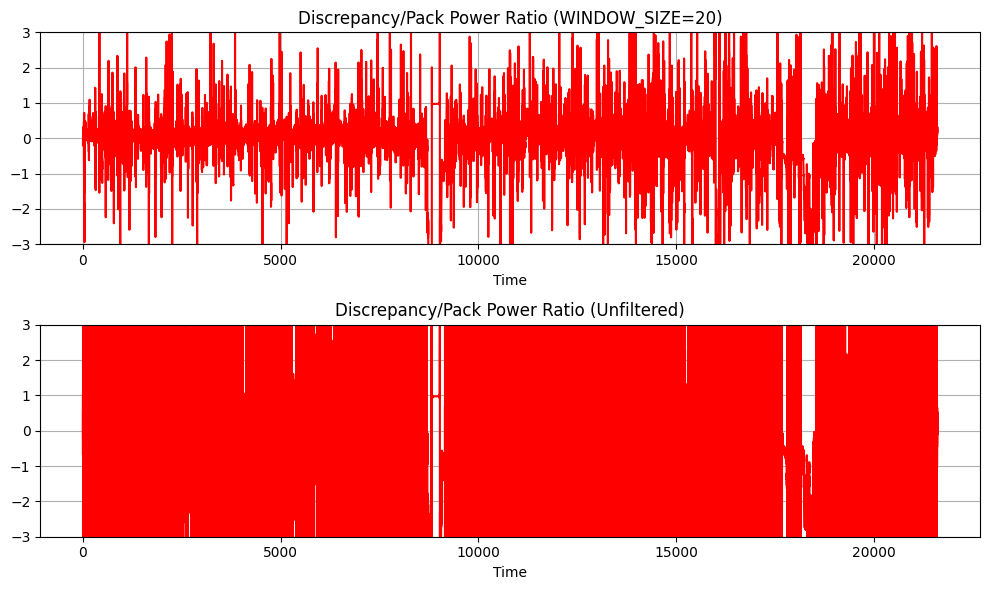

Mean Discrepancy/PackPower Ratio (Filtered):  -0.025867650323204185
Mean Discrepancy/PackPower Ratio (Uniltered):  0.06415525521877012
{'mean': np.float64(-0.025867650323204185), 'std': np.float64(1.1117966969252422), 'iqr': np.float64(0.32143720426443795), '1st_percentile': np.float64(-4.2921091550261385), '99th_percentile': np.float64(1.8755188380454337), 'majority_interval': (np.float64(-4.2921091550261385), np.float64(1.8755188380454337)), 'max': np.float64(23.51271790857402), 'min': np.float64(-19.670657971715023)}


In [20]:
# Butterworth low-pass filter design
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)  # Zero-phase filtering to avoid phase shift
    return y

# Parameters for the low-pass filter
cutoff_freq = 0.05  # Lower cutoff frequency to filter out more peaks
sampling_rate = 1.0  
filter_order = 6  # Increase filter order to make the cutoff sharper

# Power threshold for filters
threshold = 10
mask = (np.abs(discrepancy) > threshold) & (np.abs(filtered_pack_power) > threshold)

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Filtered ratio between pack power and discrepancy
raw_ratio = discrepancy[np.where(mask)] / filtered_pack_power[np.where(mask)]

# Apply the low-pass filter to the ratio
smoothed_ratio = butter_lowpass_filter(raw_ratio, cutoff_freq, sampling_rate, filter_order)

# Plot the smoothed ratio
ax[0].plot(filtered_pack_power.x_axis[np.where(mask)], smoothed_ratio, color='red')
ax[0].set_title(f'Discrepancy/Pack Power Ratio (WINDOW_SIZE={WINDOW_SIZE})')
ax[0].set_xlabel('Time')
ax[0].grid(True)
ax[0].set_ylim(-3, 3)

# Unfiltered ratio between pack power and discrepancy
aligned_motor_power, aligned_array_power = TimeSeries.align(motor_power, array_power)
unfiltered_deficit = aligned_motor_power - aligned_array_power
aligned_pack_power, unfiltered_deficit = TimeSeries.align(pack_power, unfiltered_deficit)
unfiltered_discrepancy = aligned_pack_power - unfiltered_deficit

# Apply the same epsilon threshold to unfiltered pack power
ax[1].plot(aligned_pack_power.x_axis, (unfiltered_discrepancy / aligned_pack_power), color='red')
ax[1].set_title('Discrepancy/Pack Power Ratio (Unfiltered)')
ax[1].set_xlabel('Time')
ax[1].grid(True)
ax[1].set_ylim(-3, 3)

# Plot style
plt.tight_layout()

# Show the plots
plt.show()

print("Mean Discrepancy/PackPower Ratio (Filtered): ", np.mean(smoothed_ratio))
print("Mean Discrepancy/PackPower Ratio (Uniltered): ", np.mean(unfiltered_discrepancy / aligned_pack_power))

print(summarize_timeseries(smoothed_ratio))

**Ratio** between **array power** and **discrepancy**, filtered and unfiltered

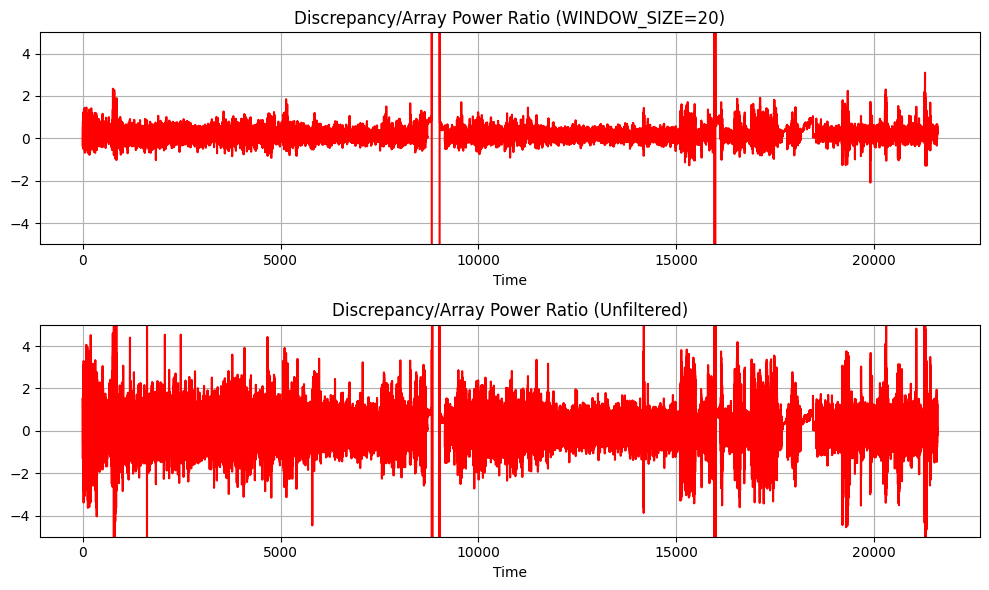

Mean Discrepancy/ArrayPower Ratio (Filtered):  -0.27917817352976865
Mean Discrepancy/ArrayPower Ratio (Uniltered):  -0.3376057759483642
{'mean': np.float64(-0.27917817352976865), 'std': np.float64(6.403310447063174), 'iqr': np.float64(0.2575976372464592), '1st_percentile': np.float64(-31.871478613415103), '99th_percentile': np.float64(0.9702669621105396), 'majority_interval': (np.float64(-31.871478613415103), np.float64(0.9702669621105396)), 'max': np.float64(147.72878861817313), 'min': np.float64(-1532.0145667628103)}
{'mean': np.float64(-0.3376057759483642), 'std': np.float64(15.574609166963752), 'iqr': np.float64(0.5409084738101847), '1st_percentile': np.float64(-31.74627150666875), '99th_percentile': np.float64(1.8607370907798464), 'majority_interval': (np.float64(-31.74627150666875), np.float64(1.8607370907798464)), 'max': np.float64(1232.1797975123422), 'min': np.float64(-3742.341296217197)}


In [21]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Filtered ratio between pack power and discrepancy
aligned_discrepancy, algn_filt_array_pwr = TimeSeries.align(discrepancy, filtered_array_power)
ax[0].plot(algn_filt_array_pwr.x_axis, (aligned_discrepancy/algn_filt_array_pwr), color='red')
ax[0].set_title(f'Discrepancy/Array Power Ratio (WINDOW_SIZE={WINDOW_SIZE})')
ax[0].set_xlabel('Time')
ax[0].grid(True)
ax[0].set_ylim(-5,5)


# # Unfiltered ratio between pack power and discrepancy
aligned_motor_power, aligned_array_power = TimeSeries.align(motor_power, array_power)
unfiltered_deficit = aligned_motor_power - aligned_array_power
aligned_pack_power, unfiltered_deficit = TimeSeries.align(pack_power, unfiltered_deficit)
unfiltered_discrepancy = aligned_pack_power - unfiltered_deficit
aligned_array_power, unfiltered_discrepancy = TimeSeries.align(aligned_array_power, unfiltered_discrepancy)

ax[1].plot(aligned_array_power.x_axis, (unfiltered_discrepancy/aligned_array_power), color='red')
ax[1].set_title('Discrepancy/Array Power Ratio (Unfiltered)')
ax[1].set_xlabel('Time')
ax[1].grid(True)
ax[1].set_ylim(-5,5)


# Plot style
plt.tight_layout()

# Show the plots
plt.show()

print("Mean Discrepancy/ArrayPower Ratio (Filtered): ", np.mean(aligned_discrepancy/algn_filt_array_pwr))
print("Mean Discrepancy/ArrayPower Ratio (Uniltered): ", np.mean(unfiltered_discrepancy/aligned_array_power))
print(summarize_timeseries(aligned_discrepancy/algn_filt_array_pwr))
print(summarize_timeseries(unfiltered_discrepancy/aligned_array_power))

**Integrate discrepency** and compare it to integral of **pack power**, filtered and unfiltered

In [22]:
# Filtered
integ_discrepancy = np.trapz(discrepancy)
integ_filt_pack_power = np.trapz(filtered_pack_power)
print("FILTERED integral comparison ----------------------")
print("Integral of Discrepancy: ", integ_discrepancy)
print("Integral of Pack Power: ", integ_filt_pack_power)
print("Difference (Pack Power - Discrepancy): " , integ_filt_pack_power - integ_discrepancy)


# Unfiltered
integ_unfilt_discrepancy = np.trapz(unfiltered_discrepancy)
integ_unfilt_pack_power = np.trapz(pack_power)
print("\nUNFILTERED integral comparison ----------------------")
print("Integral of Discrepancy: ", integ_unfilt_discrepancy)
print("Integral of Pack Power: ", integ_unfilt_pack_power)
print("Difference (Pack Power - Discrepancy): " , integ_unfilt_pack_power - integ_unfilt_discrepancy)

FILTERED integral comparison ----------------------
Integral of Discrepancy:  22009623.321806923
Integral of Pack Power:  120798194.93345936
Difference (Pack Power - Discrepancy):  98788571.61165243

UNFILTERED integral comparison ----------------------
Integral of Discrepancy:  22009921.368569802
Integral of Pack Power:  120798010.57331575
Difference (Pack Power - Discrepancy):  98788089.20474595


C:\Users\tamze\AppData\Local\Temp\ipykernel_11068\3836147687.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_discrepancy = np.trapz(discrepancy)
C:\Users\tamze\AppData\Local\Temp\ipykernel_11068\3836147687.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_filt_pack_power = np.trapz(filtered_pack_power)
C:\Users\tamze\AppData\Local\Temp\ipykernel_11068\3836147687.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_unfilt_discrepancy = np.trapz(unfiltered_discrepancy)
C:\Users\tamze\AppData\Local\Temp\ipykernel_11068\3836147687.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_unfilt_pack_powe